# Drag Racing

In this task, we design a nonlinear MPC controller to let the car to travel as far as possible in positive $x$ direction in a fixed time interval. 

The idea is to keep close to $y = 0$, while avoiding the obstacle located at $x = 500, y = 0$. 

We consider the car model with tire dynamics. 

The key to this problem is to use as much tire forces as possible, while ensuring that the car does not lose control. 

# Car Dynamics

<div>
<img src="CarModel.png" width="1200">
</div>

We consider the car dynamics with lumped rear and front tire forces. 

For simplification, we consider the positions and orientation in the world coordinates.  

\begin{aligned}
\dot{U}_x & =\frac{F_{x_f} \cos \delta-F_{y_f} \sin \delta+F_{x_r}-F_d}{m}+r U_y \\
\dot{U}_y & =\frac{F_{y_f} \cos \delta+F_{x_f} \sin \delta+F_{y_r}+F_b}{m}-r U_x \\
\dot{r} & =\frac{a\left(F_{y_f} \cos \delta+F_{x_f} \sin \delta\right)-b F_{y_r}}{I_{z z}} \\
\dot{x} & = \cos(\phi)U_x - \sin(\phi)U_y  \\
\dot{y} & = \sin(\phi)U_x + \sin(\phi)U_y   \\ 
\dot{\phi} & =r  . \\
\end{aligned}


We consider the Euler first order integration to discretize the model. 

The actual control input of the vehicle is the traction force $F_w$ and steering angle $\delta$, which implicitly appears in the vehicle dynamics via the tire force $F_{x_f}$, $F_{y_f}$, $F_{x_r}$ and $F_{y_r}$.   

## Model parameter

The meaning of the model parameters are provided in the following charts. Please refer to the **Param** variable in **utils.py** for the actual values.

<div>
<img src="assets/Param.png" width="600">
</div>


Laurense, V.A. and Gerdes, J.C., 2021. Long-horizon vehicle motion planning and control through serially cascaded model complexity. IEEE Transactions on Control Systems Technology, 30(1), pp.166-179.

## Modified tire model for control and optimization

The brush tire model saturated when the slip angle is greater than the threshold. Such saturated region will result in zero gradient, which is harmful for optimization. 

To solve the problem, we introduce the modified tire model for control, such that the tire forces will not saturated. 

We consider the modified maximal lateral tire force:
$$
\tilde{F}^{\max}_{y} = \sqrt{(\mu F_z)^2 - (0.99\tilde{F}_x)^2 }
$$
We here add an additional coefficient $0.99$ to avoid exceeding the friction limits. 

Then we introduce an variable $\xi$ and define the modified slide sliping angle:

$$
\alpha^{mod} = \arctan{\left( \frac{3F_y^{\max}\xi }{C_{\alpha}} \right)}. 
$$

Finally, we have the modified brush tire model for control:

\begin{aligned}
\tilde{F}_y&=\left\{\begin{array}{l}
-C_\alpha \tan \alpha
+\frac{C_\alpha^2}{3 \tilde{F}_y^{\max }}|\tan \alpha| \tan \alpha
-\frac{C_\alpha^3}{27\left(\tilde{F}_y^{\max }\right)^2} \tan ^3 \alpha
-C_\alpha\left(1-2 \xi+\xi^2\right) \tan \alpha \quad \text { if }|\alpha| \leq \alpha^{\bmod } \\

-\tilde{F}_y^{\max }\left(3 \xi^2-2 \xi^3\right) \operatorname{sgn} \alpha \quad \text { otherwise }
\end{array}\right. \\
& =\tilde{f}_{\text {tire }}\left(\alpha, F_z, F_x\right) \text {. } \\
&
\end{aligned}

We let $\xi$ be $0.85$ and provides the plot for comparison with the brush tire model. The dashed lines are the brush tire model without the modification. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import casadi as ca
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

import scipy.io

from utils import *
from sim import *
from nmpc_dragracing import *

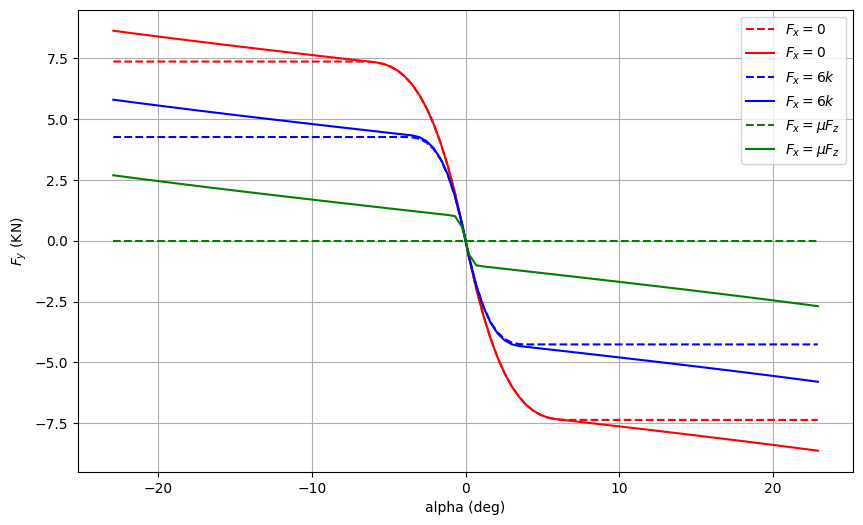

In [3]:
Fx = 0.0
alpha = np.linspace(-0.4, 0.4, 100)

plt.figure(figsize=(10, 6))

Fy = tire_model_sim(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r--", label = "$F_x = 0$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r-",  label = "$F_x = 0$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b--", label = "$F_x = 6k$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b-",  label = "$F_x = 6k$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g--", label = "$F_x = \mu F_z$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g-", label = "$F_x = \mu F_z$")

plt.ylabel("$F_y$ (KN)")
plt.xlabel("alpha (deg)")
plt.legend()
plt.grid("on")

## Nonlinear Model Predictive Control

Let the state of the car be

$$
s_k:= \left[U_{x,k}, U_{y,k}, r_k, x_k, y_k, \phi_k \right], k = 0, 1, \dots, N. 
$$

Let the control input of the car be 

$$
u_k:= \left[ F_{x, k}, \delta_{k} \right], k = 0, 1, \dots, N-1.
$$

We introduce four auxiliary variable for each step:

$$
z_k:=\left[F_{y_f, k}, F_{y_r, k}, z_{\mu_f}, z_{\mu_r}\right], k = 0, 1, \dots, N-1.
$$

The first two variables will be used to enforce the tire force constraints, which means $F_{y_f, k}$ and $F_{y_r, k}$ will be explicit variables and related to traction force $F_x$ and steering angle $\delta$ via tire model. The last two will be used to slack the friction cone constraints. 

The reason of introducing auxiliary variables is that more variabel sometimes results in less nonlinearity. 

Thus the NMPC problem will take the form:

$$
    \begin{aligned}
    J_0^{*}(s_{init}) = \min_{s_k, u_k, z_k} & \ p(s_N) + \sum_{k=0}^{N-1} q(s_k, u_k, z_k)\\ 
    \text{s.t. } 
                %  & x_{k+1} =  \ k = 0, \dots, N-1, \\
                & s_{k+1} = f(s_k, u_k, z_k), k = 0, \dots, N-1, \\
                & 0=TireModel(s_k, u_k, z_k), \\
                & FrictionCone(s_k, z_k, u_k) \le 0, \\
                & OtherConstraints(s_k, z_k, u_k) \le 0, \\
                & u_{\min} \le u_k \le u_{\max}, \\
                & x_0 = x_{init}. 
    \end{aligned}
$$

## Detail of constraints
### Friction cone constraints:

We introduce the slacked friction cone constraints:

$$ F_{y_f, k}^2 + F_{x_f, k}^2 \le (\mu_f F_{z_f, k})^2 + z_{\mu_f}^2  $$
$$ F_{y_r, k}^2 + F_{x_r, k}^2 \le (\mu_r F_{z_r, k})^2 + z_{\mu_r}^2  $$


### Obstacle avoidance:

The car should avoid colliding with the sphere obstacle:

$$ \left(\frac{x_k - 500}{10}\right)^2 + \left(\frac{y_k}{10}\right)^2 \ge 1  $$

### Input constraints:

Steering angle can not exceed the maximal value:
$$-\delta_{\max} \le \delta_k \le \delta_{\max}$$

Traction force can not exceed the engine power constraints:
$$ F_x \le \frac{P_{eng}}{U_x }$$

### Positive longitudinal speed

We do not want to drive in reverse:

$$ U_x \ge 2 $$

## Cost function design

### Stay close to the "lane":

Design a cost function to encourage the car to approach the lane: $y_k \rightarrow 0$. 

### Stabilize the yaw angle:

Design a cost function to encourage the car to maintain zero yaw angle: $\phi_k \rightarrow 0$. 

### Drive fast / far:

Design a cost function to encourage the car to drive as fast as possible, i.e. $U_x \rightarrow +\infty$ and $x \rightarrow +\infty$

### Avoid tire saturation:

Design a cost function to encourage the slip angle be smaller than the modified slip angle: 

$$
J_\alpha=W_\alpha \sum_{k=1}^N \begin{cases}\left(\left| \alpha_{k}\right|- \alpha_{k}^{\bmod }\right)^2, & \text { if }\left| \alpha_{k}\right| \geq \alpha_{k}^{\bmod } \\ 0, & \text { otherwise. }\end{cases}
$$

where $W_{\alpha}$ is a large weight. The $\alpha^{mod}$ is the modified slide slipping angle. 

### Penalize the slack variable of friction cone constraints:

Add a large weight to $z_{\mu_{f}}^2$ and $z_{\mu_{r}}^2$. 

### Initial guess for warm-start:

The initial guess of the NMPC solver for warm-start, i.e. the **\*.mat** files, are computed offline (until convergence). These files are dependent on the built controller.

These are generated on $5$ known test cases.

### Evaluation:

Evaluation is done on the closed-loop trajectory based on the distance traveled in the $x$ direction and the deviation in $y$ direction. 

Larger distance in $x$ direction and less deviation from $y$ is better (& no Collision with obstacle). 

## Remark

In runtime, the NMPC is not required to converge to optimal value. We set the **ipopt.max_iter** to $3000$ make sure the simulation time is reasonable. 

As long as the NMPC is **feasible**, suboptimal solution can still stabilize the system as long as the suboptimality is not too big. 

## Code start

### Get an NMPC controller

In [4]:
## build a controller 
prob, N_mpc, n_x, n_g, n_p, lb_var, ub_var, lb_cons, ub_cons = nmpc_controller(None)

### Compute the solution for initial condition

Here we compute the solution of our NMPC controller for each initial conditions and save it as a **case_#.mat** file. 

Only uncomment one line each time and continue. 

We've used random initialization as the initial guess for the 1st case, for other cases we've resused the case_1.mat as initial guess, except for case_5 where we used case_4.mat as the initial guess. 

In [5]:
## random initialization
# x0_nlp    = np.random.randn(n_x, 1) * 0.01 #0.005 or 0.008 or 0.01 
# lamx0_nlp = np.random.randn(n_x, 1) * 0.01 # 
# lamg0_nlp = np.random.randn(n_g, 1) * 0.01 # 

## initialization using known solution
initial_guess = scipy.io.loadmat("case_4.mat") # Once you have a solution, you can use it as initial guess for other cases
x0_nlp = initial_guess["x0_nlp"]
lamx0_nlp = initial_guess["lamx0_nlp"]
lamg0_nlp = initial_guess["lamg0_nlp"]

## uncomment one line each time 
init = np.array([50, 0.0, 0.0, 0,  0, 0]); file_name = "case_1.mat"
# init = np.array([3, 0.0, 0.0, 0,  0, 0]); file_name = "case_2.mat"
# init = np.array([30, 0.0, 0., 0,  30, 0]); file_name = "case_3.mat"
# init = np.array([30, 0.0, 0.0, 0,  50, 0.3]); file_name = "case_4.mat"
# init = np.array([3, 0.0, 0.0, 0, 30, 1.57]); file_name = "case_5.mat"

## run sufficiently long time to ensure the solver converges to optimal value
opts = {'ipopt.max_iter':3000}

solver = ca.nlpsol('solver', 'ipopt', prob , opts)
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1356
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      694

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      366
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality c

### Compare the solution after warm-start

You can find the solver is fast if the initial guess is properly provided. 

Save the initial guess for your simulations. 

In [6]:
## you will see how fast the solver is if it is initialized properly
x0_nlp    = sol["x"].full()
lamx0_nlp = sol["lam_x"].full()
lamg0_nlp = sol["lam_g"].full() # np.zeros((n_g, 1))
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)

## save the initial guess if you are satisfied
scipy.io.savemat(file_name, {'x0_nlp': x0_nlp, "lamx0_nlp": lamx0_nlp, "lamg0_nlp": lamg0_nlp})

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1356
Number of nonzeros in inequality constraint Jacobian.:      480
Number of nonzeros in Lagrangian Hessian.............:      694

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      366
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0149943e+09 1.52e-08 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [7]:
## You can plot the solution here to see if it is reasonable. 

u = sol["x"].full()[0:N_mpc * 2]
x = sol["x"].full()[N_mpc * 2:N_mpc * 2 + (N_mpc + 1) * 6]

### Retrive the initial solutions for simulation. 

If you already have the initial solutions, you can start from this block to retrive them. 

In [8]:
## test the controller with different initial states and guesses
## uncomment one line each time and test the controller
init = np.array([50, 0.0, 0.0, 0,  0, 0]); file_name = "case_1.mat"
# init = np.array([3, 0.0, 0.0, 0,  0, 0]); file_name = "case_2.mat"
# init = np.array([30, 0.0, 0., 0,  30, 0]); file_name = "case_3.mat"
# init = np.array([30, 0.0, 0.0, 0,  50, 0.3]); file_name = "case_4.mat"
# init = np.array([3, 0.0, 0.0, 0, 30, 1.57]); file_name = "case_5.mat"

initial_guess = scipy.io.loadmat(file_name)
x0_nlp = initial_guess["x0_nlp"]
lamx0_nlp = initial_guess["lamx0_nlp"]
lamg0_nlp = initial_guess["lamg0_nlp"]

### Simulation start! 

We will simulate the vehicle for 30 secs. 

As we are using fixed-step RK simulator and limits the maximal iteration for IPOPT, the simulation time is controllable. 

In [9]:
## build a car simulator
## The car will be driving for 30 secs
## The control rate is 10 HZ.
T_sim  = 30
dt_ctrl = 0.1; rk_interval = 10
N_sim = int(np.ceil(T_sim / dt_ctrl))
integrator, car_dynamics = GetCarModel(None, ts = np.linspace(0, dt_ctrl, rk_interval), ode = "rk")
sim_time = np.linspace(0, T_sim, N_sim * (rk_interval - 1) + 1)

CasADi - 2024-07-19 01:34:09 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [10]:
y0 = np.reshape(init, (6, 1))
x_log, u_log, tire_force_log = SimVehicle(y0, nmpc_controller, integrator, car_dynamics, N_sim, True, x0_nlp, lamx0_nlp, lamg0_nlp)

Total number of variables............................:      366
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      366
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      150
        inequality constraints with only upper bounds:        0


Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.5474732642731324e+05    1.0149942704190080e+09
Dual infeasibility......:   1.0140888762609771e-10    4.0404522141049027e-07
Constraint violation....:   2.4339650005416012e-11    1.5650327256366836e-08
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

### Trajectory

We are supposed to avoid the obstacle, while trying to keep $y = 0$ and reach larger $x$. 

In [11]:
print("Distance traveled in x direction:")
print(np.max(x_log[3, :]))

print("std. dev in y direction:")
print(np.std(x_log[4, :]))

Distance traveled in x direction:
1030.2320753451418
std. dev in y direction:
3.7919900875633115


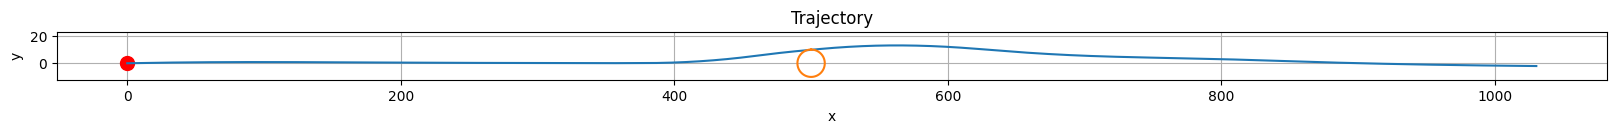

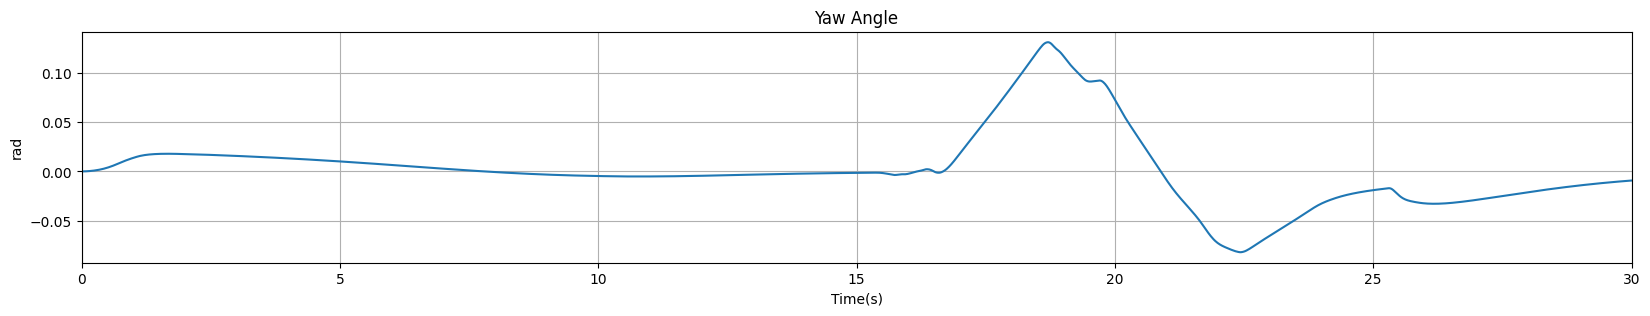

In [12]:
# trajectory in the world frame

plt.figure(figsize=(20, 10))
plt.plot(x_log[3, 0], x_log[4, 0], "r.", markersize = 20)
plt.plot(x_log[3, :], x_log[4, :])
plt.axis("scaled")

plt.title("Trajectory")
plt.xlabel("x")
plt.ylabel("y")

theta = np.linspace(0, np.pi * 2, 100)
plt.plot(np.sin(theta) * 10 + 500, np.cos(theta) * 10)
plt.ylim([np.min(x_log[4, :]) -10, np.max(x_log[4, :]) + 10])

plt.grid()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(sim_time, x_log[5])
plt.xlim([0, T_sim])
plt.title("Yaw Angle")
plt.xlabel("Time(s)")
plt.ylabel("rad")
plt.grid()
plt.show()

### Velocity

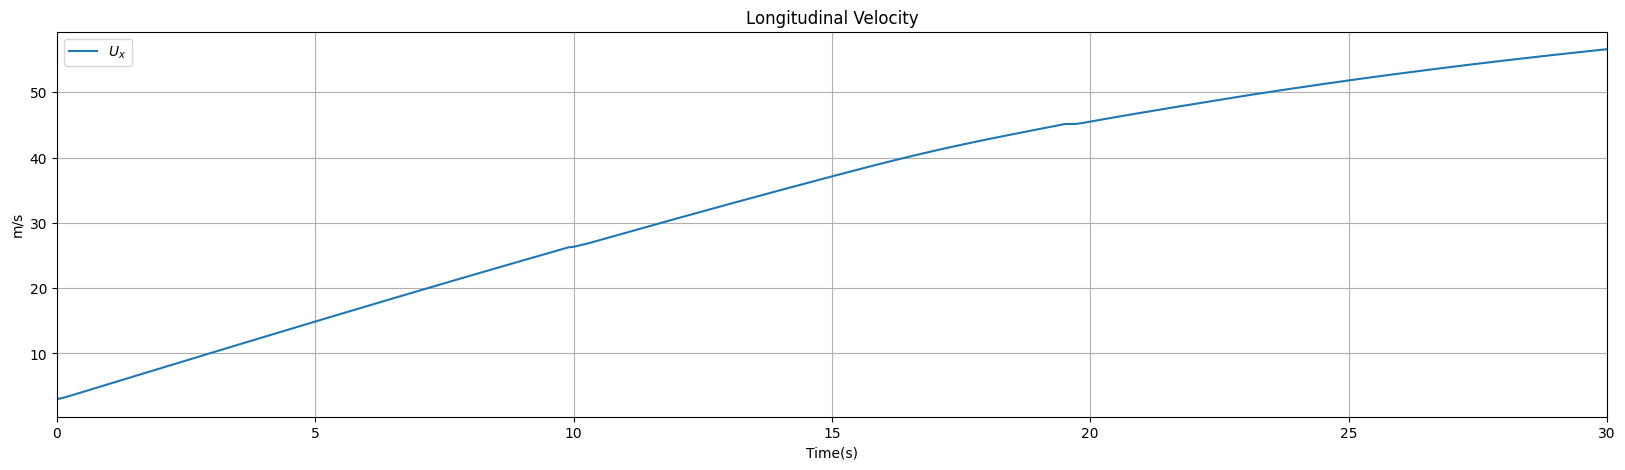

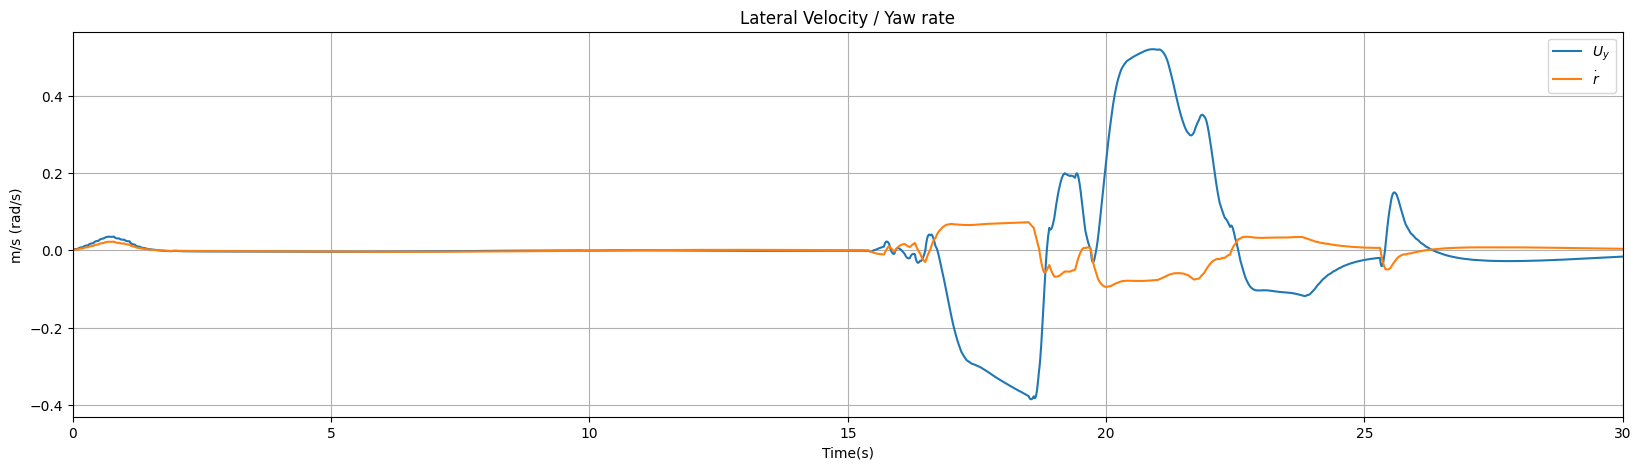

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(sim_time, x_log[0, :], label = "$U_x$" )
plt.xlim([0, T_sim])

plt.title("Longitudinal Velocity")
plt.xlabel("Time(s)")
plt.ylabel("m/s")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(sim_time, x_log[1, :], label = "$U_y$" )
plt.plot(sim_time, x_log[2, :], label = "$\dot{r}$" )
plt.xlim([0, T_sim])

plt.title("Lateral Velocity / Yaw rate")
plt.xlabel("Time(s)")
plt.ylabel("m/s (rad/s)")
plt.legend()
plt.grid()
plt.show()

### Control input

The traction force will decrease due to the engine power limits when the velocity is large. 

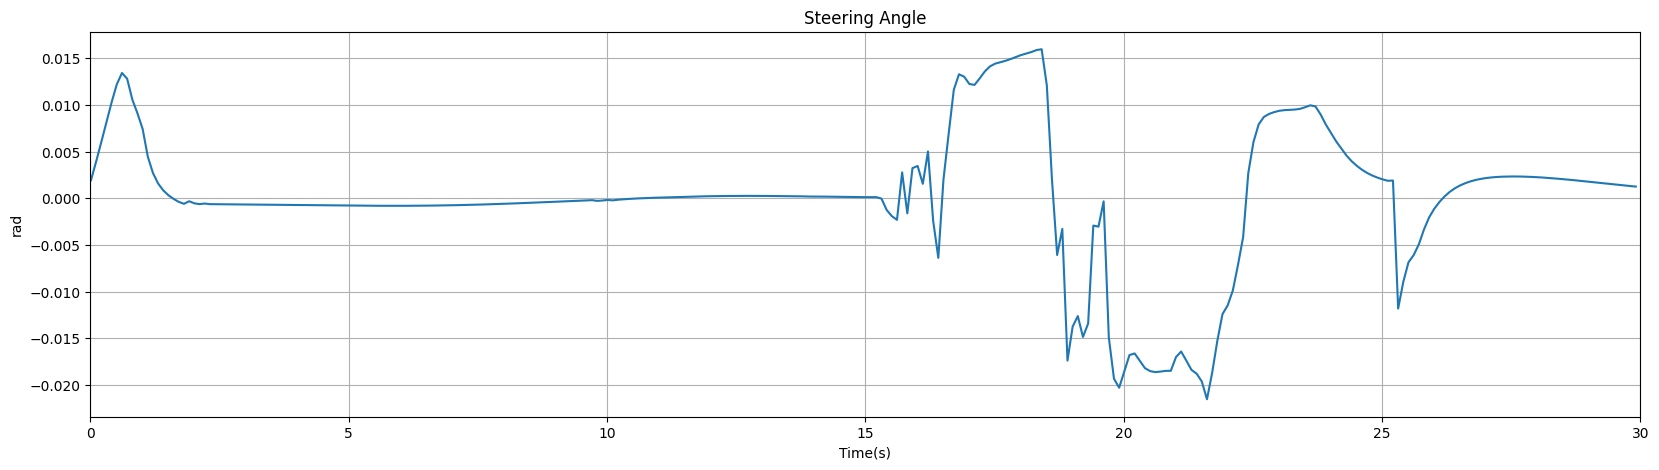

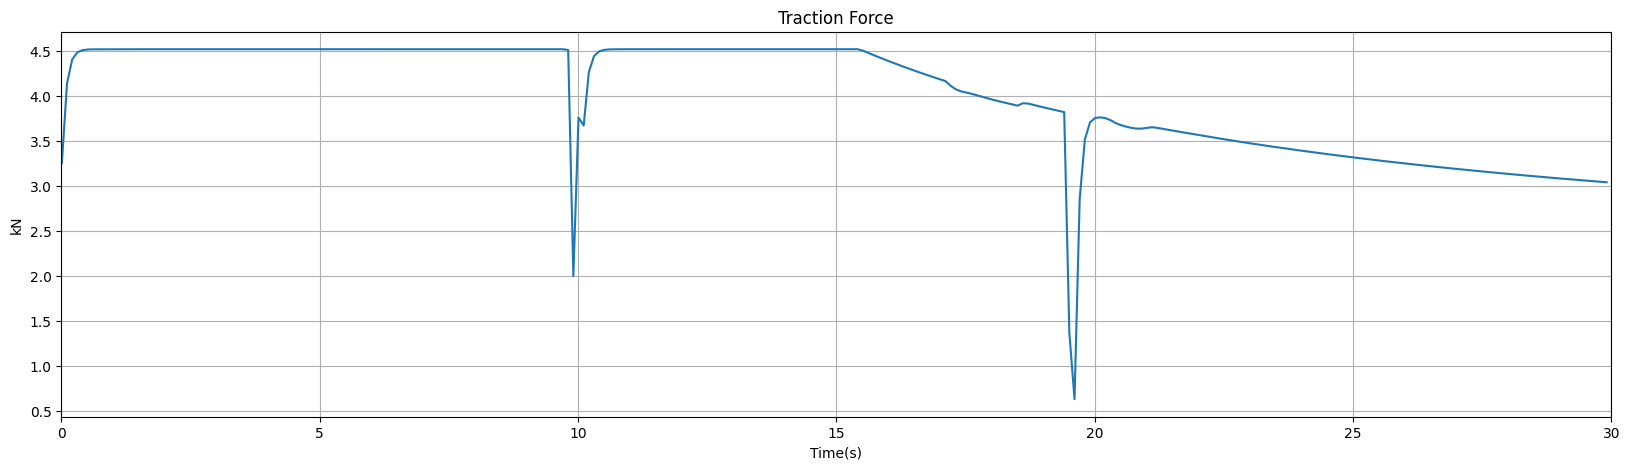

In [14]:
rk_interval = 10
plt.figure(figsize=(20, 5))
plt.plot(sim_time[1::rk_interval-1], u_log[1, 1:])
plt.xlim([0, T_sim])
plt.title("Steering Angle")
plt.xlabel("Time(s)")
plt.ylabel("rad")
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(sim_time[1::rk_interval-1], u_log[0, 1:] / 1000)
plt.xlim([0, T_sim])
plt.title("Traction Force")
plt.xlabel("Time(s)")
plt.ylabel("kN")
plt.grid()
plt.show()

### Tire force

For successful trial, the tire force should distributed at the boundary of the friction cone for larger acceleration and braking. 

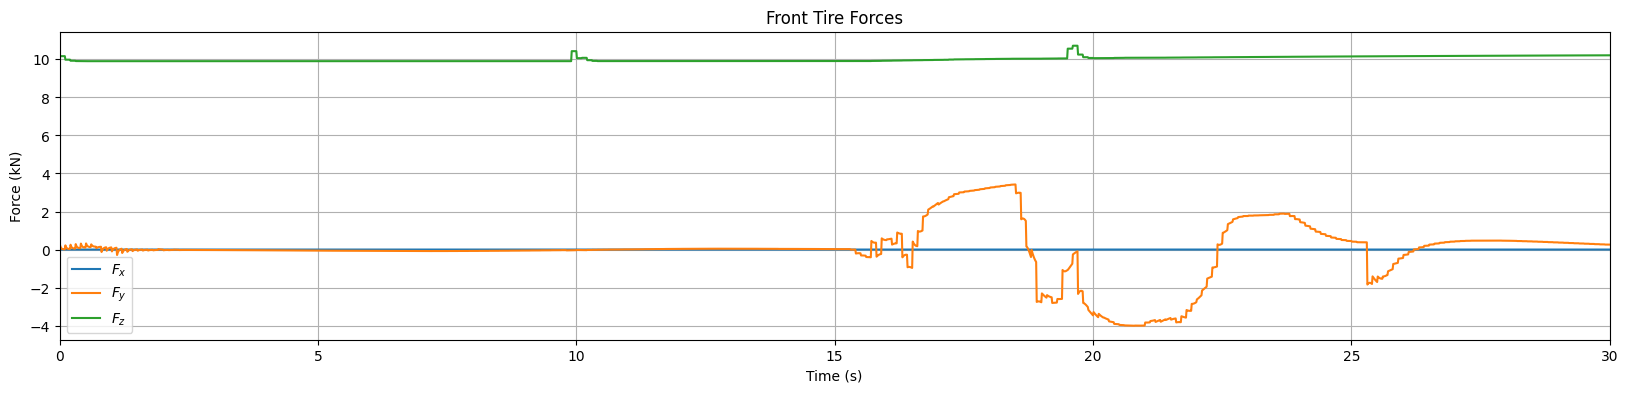

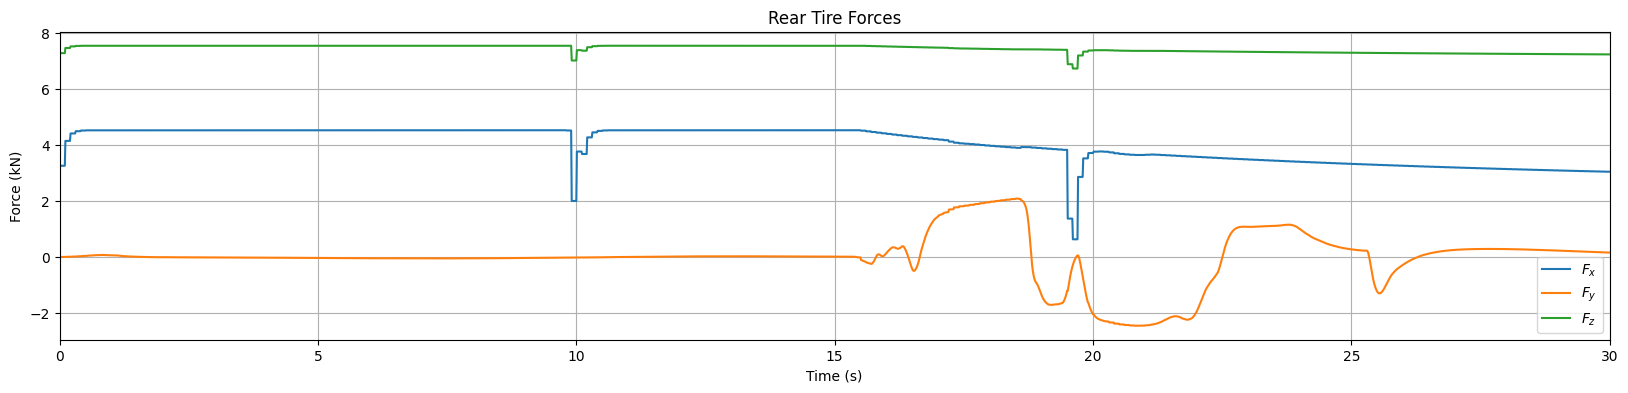

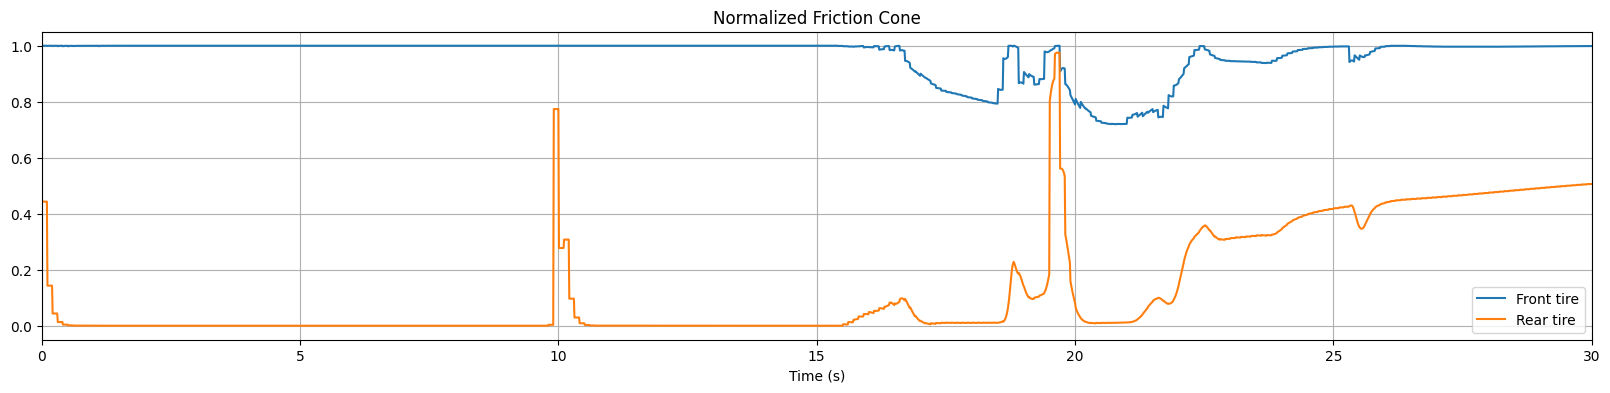

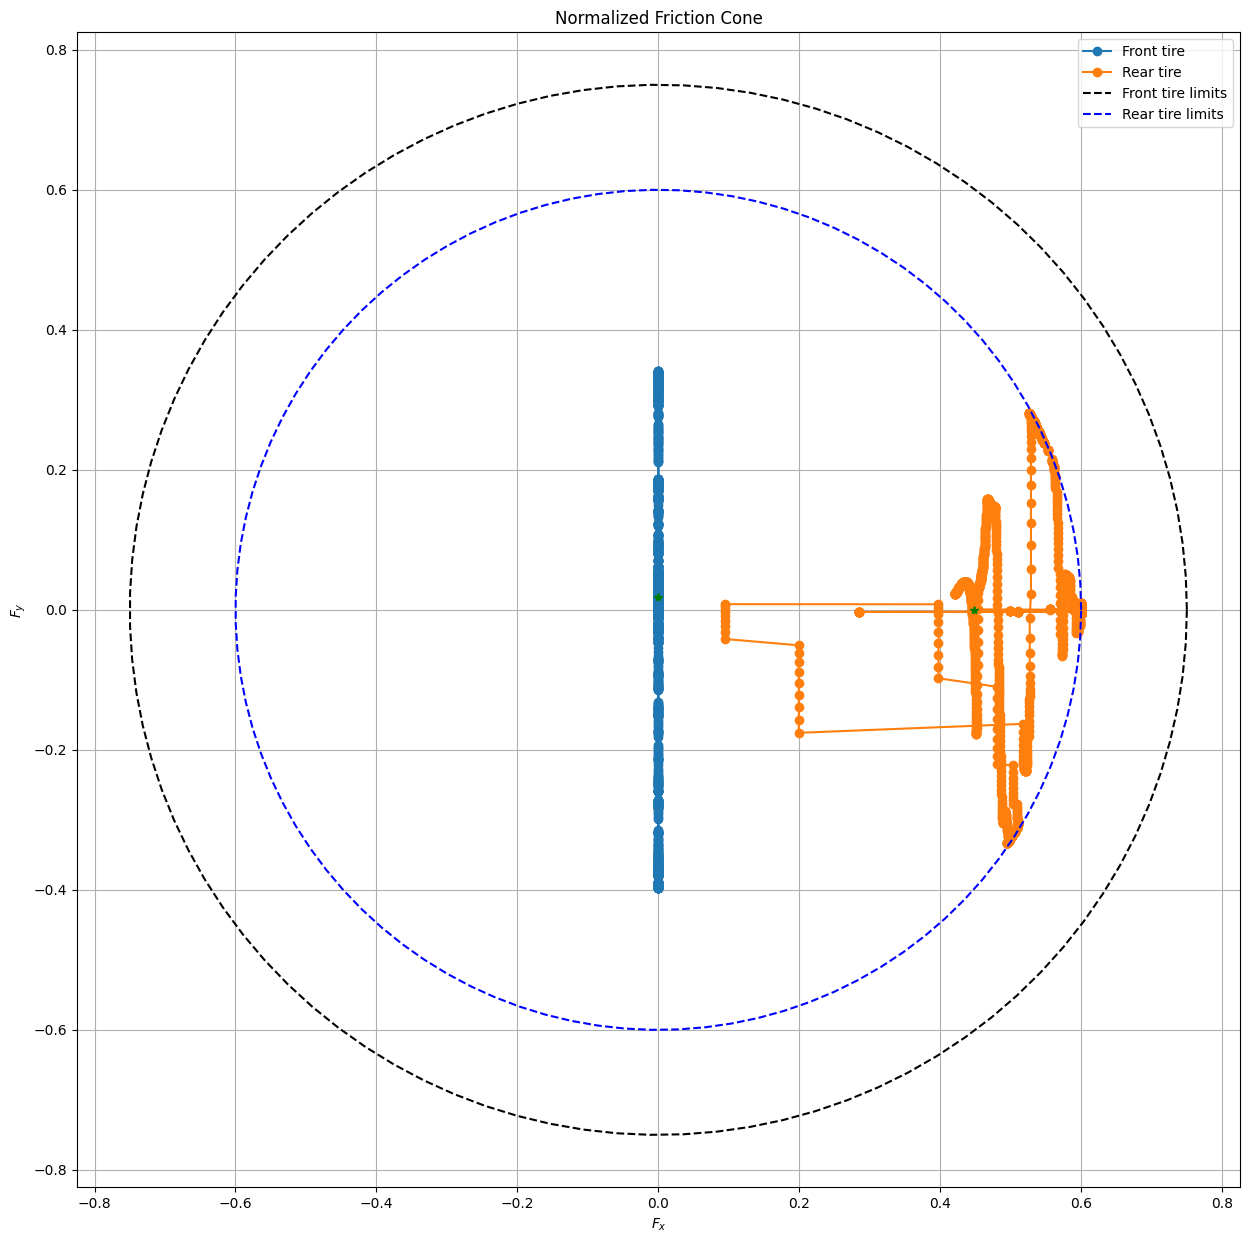

In [15]:
rk_interval = 2
plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], tire_force_log[0:3, 1:].T / 1000)
plt.title("Front Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (kN)")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], tire_force_log[4:7, 1:].T / 1000)
plt.title("Rear Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (kN)")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.grid()
plt.show()

inter = 1
Fx_f = tire_force_log[0, 1::inter].T / tire_force_log[2, 1::inter].T
Fy_f = tire_force_log[1, 1::inter].T / tire_force_log[2, 1::inter].T

Fx_r = tire_force_log[4, 1::inter].T / tire_force_log[6, 1::inter].T
Fy_r = tire_force_log[5, 1::inter].T / tire_force_log[6, 1::inter].T

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1::rk_interval-1], 1 - (Fx_f**2 + Fy_f**2) / param["mu_f"]**2 , label = "Front tire" )
plt.plot(sim_time[1::rk_interval-1], 1 - (Fx_r**2 + Fy_r**2) / param["mu_r"]**2 , label = "Rear tire" )
plt.title("Normalized Friction Cone")
plt.xlabel("Time (s)")
plt.xlim([0, T_sim])
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 15))
plt.plot(Fx_f, Fy_f , "-o",  label = "Front tire" )
plt.plot(Fx_r, Fy_r , "-o", label = "Rear tire" )

plt.plot(Fx_f[0], Fy_f[0] , "g*")
plt.plot(Fx_r[0], Fy_r[0] , "g*")

plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], "k--", label = "Front tire limits")
plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], "b--", label = "Rear tire limits")

plt.title("Normalized Friction Cone")
plt.ylabel("$F_y$")
plt.xlabel("$F_x$")
plt.legend()
plt.grid()
plt.show()

# Lets Animate the vehicle now

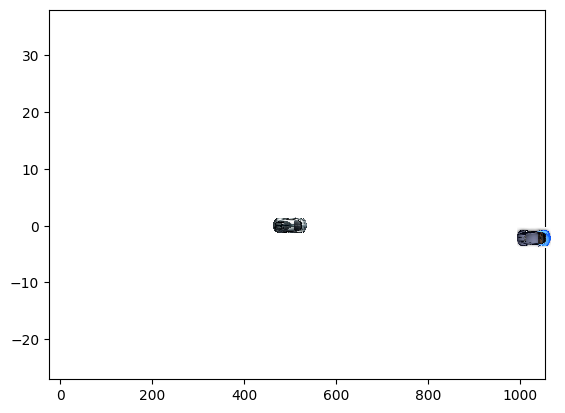

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.ndimage import rotate

ego_position_x = x_log[3, :]
ego_position_y = x_log[4, :]
ego_orientation = x_log[5]  # Orientation of the car

leading_position_x = np.zeros(len(ego_position_x))
leading_position_x.fill(500)

leading_position_y = np.zeros(len(ego_position_x))
leading_position_y.fill(0)




# Set up the figure and axis
fig, ax = plt.subplots()

ax.set_xlim(min(ego_position_x)-10, max(ego_position_x)+10)
ax.set_ylim(min(leading_position_y)-10, max(leading_position_y)+10)

# Load an image to use as the cursor (point)
ego_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Trajectory Optimization\CarOvertaking\assets\bugatti.jpg')
leading_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Trajectory Optimization\CarOvertaking\assets\bugatti-black.jpg')  

# Create OffsetImage objects for the moving images
ego_vehicle_image = OffsetImage(ego_car_image, zoom=0.04)
leading_vehicle_image = OffsetImage(leading_car_image, zoom=0.04)

# Create AnnotationBbox objects for placing the images on the plot
ego_vehicle_ab = AnnotationBbox(ego_vehicle_image, (ego_position_x[0], ego_position_y[0]), frameon=False)
leading_vehicle_ab = AnnotationBbox(leading_vehicle_image, (leading_position_x[0], leading_position_y[0]), frameon=False)

# Add the AnnotationBbox objects to the axis
ax.add_artist(ego_vehicle_ab)
ax.add_artist(leading_vehicle_ab)

# Text for displaying time and distance information
distance_text = ax.text(0.05, 1.95, '', transform=ax.transAxes)

# Container for the AnnotationBbox objects
container = {
    'ego_vehicle_ab': ego_vehicle_ab,
    'leading_vehicle_ab': leading_vehicle_ab,
    'distance_text': distance_text
}


def init():
    container['ego_vehicle_ab'].xy = (ego_position_x[0], ego_position_y[0])
    container['leading_vehicle_ab'].xy = (leading_position_x[0], leading_position_y[0])
    # distance_text.set_text('')
    container['distance_text'].set_text('')
    return container['ego_vehicle_ab'], container['leading_vehicle_ab']

def update(frame):
    # Remove the previous AnnotationBbox objects
    container['ego_vehicle_ab'].remove()
    container['leading_vehicle_ab'].remove()

    # Rotate the car image based on the vehicle's orientation
    angle = np.rad2deg(ego_orientation[frame])
    rotated_image_array = rotate(ego_car_image, angle, reshape=True, mode='constant', cval=255)
    rotated_image = OffsetImage(rotated_image_array, zoom=0.04)
    
    # Create new AnnotationBbox objects with updated positions and orientation
    container['ego_vehicle_ab'] = AnnotationBbox(rotated_image, (ego_position_x[frame], ego_position_y[frame]), frameon=False)
    container['leading_vehicle_ab'] = AnnotationBbox(leading_vehicle_image, (leading_position_x[frame], leading_position_y[frame]), frameon=False)

    # Add the new AnnotationBbox objects to the axis
    ax.add_artist(container['ego_vehicle_ab'])
    ax.add_artist(container['leading_vehicle_ab'])

   
    # Update the text
    # distance_text.set_text(f'Distance between vehicles: {ego_position_x[frame]:.2f}m \n Ego velocity: {xt[frame, 3]+x_init[4]:.2f}, Leading velocity: {x_init[4]:.2f}')
    # container['distance_text'].set_text(f'Distance between vehicles: {ego_position_x[frame]:.2f}m \nEgo velocity: {xt[frame, 3]+x_init[4]:.2f} m/s, Leading velocity: {x_init[4]:.2f} m/s')

    # Update the x-axis limits
    ax.set_xlim(min(ego_position_x) - 25, max(ego_position_x) + 25)
    ax.set_ylim(min(ego_position_y) - 25, max(ego_position_y) + 25)

    return container['ego_vehicle_ab'], container['leading_vehicle_ab']

ani = animation.FuncAnimation(fig, update, frames=len(ego_position_y), init_func=init, interval=10, blit=True, repeat=False)

# Save the animation
ani.save('vehicle_simulation.mp4', writer='ffmpeg')
